In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) > 0.8

In [57]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2022-03-14 08:21:55.211,3223,23172,1.00,0.000631,32482.0,{'AA': 'C'}
1,next,2022-03-14 08:21:55.220,3223,32482,0.01,0.000504,1920.0,{'AA': 'C'}
2,next,2022-03-14 08:21:55.227,3223,1920,0.01,0.000505,13708.0,{'AA': 'C'}
3,next,2022-03-14 08:21:55.235,3223,13708,0.00,0.000585,14430.0,{'AA': 'C'}
4,next,2022-03-14 08:21:55.243,3223,14430,0.01,0.000578,24610.0,{'AA': 'C'}


In [58]:
positives.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,test
0,next,2022-03-14 08:21:55.211,3223,23172,1.00,0.000631,32482.0,{'AA': 'C'},False
6,next,2022-03-14 08:21:55.283,3418,40080,1.00,0.000753,49993.0,{'AA': 'T1'},True
8,next,2022-03-14 08:21:55.298,3418,36905,0.82,0.000443,32469.0,{'AA': 'T1'},False
15,next,2022-03-14 08:21:55.356,3418,30751,1.00,0.000525,29698.0,{'AA': 'T1'},False
18,next,2022-03-14 08:21:55.403,3655,2262,1.00,0.000547,23981.0,{'AA': 'C'},False


## Train LightFM

In [8]:
train_data = positives[~positives["test"]]
test_data = positives[positives["test"]]

In [53]:
dataset = ld.Dataset()
dataset.fit(positives["user"], positives["track"])

In [54]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [61]:
train_interactions.todense().sum(axis=1)

matrix([[ 9.],
        [18.],
        [ 6.],
        ...,
        [ 1.],
        [ 1.],
        [ 1.]], dtype=float32)

In [66]:
train_data[train_data["user"] == 3223]

,message,timestamp,user,track,time,latency,recommendation,experiments,test
0,next,2022-03-14 08:21:55.211,3223,23172,1.00,0.000631,32482.0,{'AA': 'C'},False
10464,next,2022-03-14 08:24:09.939,3223,21500,1.00,0.000659,47577.0,{'AA': 'C'},False
10467,next,2022-03-14 08:24:09.962,3223,23860,0.89,0.000589,30651.0,{'AA': 'C'},False
36871,next,2022-03-14 08:29:09.611,3223,46887,1.00,0.000852,24509.0,{'AA': 'C'},False
168053,next,2022-03-14 08:54:35.467,3223,49219,1.00,0.000519,41619.0,{'AA': 'C'},False
168060,next,2022-03-14 08:54:35.519,3223,10005,0.87,0.000478,38793.0,{'AA': 'C'},False
295870,next,2022-03-14 09:18:54.329,3223,21193,1.00,0.000569,28070.0,{'AA': 'C'},False
298345,next,2022-03-14 09:19:21.735,3223,34312,1.00,0.000476,44235.0,{'AA': 'C'},False
460754,next,2022-03-14 09:52:31.794,3223,14737,1.00,0.000622,43366.0,{'AA': 'C'},False


In [65]:
dataset.mapping()[0]

{3223: 0,
 3418: 1,
 3655: 2,
 9746: 3,
 6020: 4,
 4769: 5,
 4295: 6,
 944: 7,
 9616: 8,
 5821: 9,
 3267: 10,
 5297: 11,
 4753: 12,
 7410: 13,
 7515: 14,
 5631: 15,
 5536: 16,
 7532: 17,
 4213: 18,
 9633: 19,
 6970: 20,
 4512: 21,
 4764: 22,
 4003: 23,
 480: 24,
 1450: 25,
 2701: 26,
 8153: 27,
 235: 28,
 4054: 29,
 5847: 30,
 6887: 31,
 7955: 32,
 7353: 33,
 7979: 34,
 3641: 35,
 4351: 36,
 3767: 37,
 3911: 38,
 7003: 39,
 4801: 40,
 3528: 41,
 5771: 42,
 162: 43,
 3182: 44,
 465: 45,
 1082: 46,
 2066: 47,
 6502: 48,
 9357: 49,
 7486: 50,
 2525: 51,
 2866: 52,
 2898: 53,
 6126: 54,
 7792: 55,
 416: 56,
 7127: 57,
 8435: 58,
 4718: 59,
 888: 60,
 398: 61,
 4555: 62,
 2339: 63,
 5411: 64,
 4872: 65,
 3324: 66,
 4785: 67,
 9618: 68,
 3602: 69,
 4336: 70,
 503: 71,
 6701: 72,
 7920: 73,
 2785: 74,
 2310: 75,
 1377: 76,
 7315: 77,
 5549: 78,
 8485: 79,
 3199: 80,
 3812: 81,
 3261: 82,
 4648: 83,
 8559: 84,
 4148: 85,
 706: 86,
 8196: 87,
 6954: 88,
 5319: 89,
 862: 90,
 5447: 91,
 605: 92,

In [55]:
def fit_model(epochs=30, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["bpr", "warp"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [56]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)
best_params = study.best_params

[I 2022-03-14 16:16:50,812] A new study created in memory with name: no-name-d9fd0f1d-820a-4261-8365-de0c230314e6
[I 2022-03-14 16:17:02,672] Trial 0 finished with value: 0.0025101015344262123 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.01}. Best is trial 0 with value: 0.0025101015344262123.
[I 2022-03-14 16:17:22,231] Trial 1 finished with value: 0.0027549895457923412 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.001, 'item_alpha': 0.001}. Best is trial 1 with value: 0.0027549895457923412.


In [45]:
best_params

{'loss': 'bpr',
 'no_components': 10,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.01,
 'item_alpha': 0.001}

In [52]:
model, precisions_at = fit_model(
    epochs=30,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.000538753520231694 +/- 0.0001587718254995448
1:	0.0006244643591344357 +/- 0.00017086179927372784
2:	0.000269376760115847 +/- 0.00011242055668637473
3:	0.00018366597942076623 +/- 9.286809684451755e-05
4:	0.000146932783536613 +/- 8.307903060526384e-05
5:	8.571079524699599e-05 +/- 6.347210982983614e-05
6:	0.00023264357878360897 +/- 0.00010449394328199825
7:	0.00026937673101201653 +/- 0.00011242055668637473
8:	0.000244887953158468 +/- 0.00010720194187688637
9:	8.571079524699599e-05 +/- 6.347210982983614e-05
10:	0.000122443976579234 +/- 7.584973428736751e-05
11:	0.00022039917530491948 +/- 0.00010171317861824122
12:	0.00022039916075300425 +/- 0.00010171317861824122
13:	0.00015917717246338725 +/- 8.646609669795116e-05
14:	0.000146932783536613 +/- 8.307903060526384e-05
15:	6.1221988289617e-05 +/- 5.365029633474517e-05
16:	0.000146932783536613 +/- 8.307903060526384e-05
17:	0.00020815477182623 +/- 9.885352765830996e-05
18:	0.00019591038289945573 +/- 9.590787033578498e-05
19:	0.0001591771870

KeyboardInterrupt: 

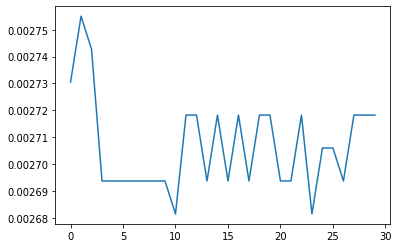

In [23]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [24]:
biases, embeddings = model.get_item_representations()

In [25]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [26]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [27]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [28]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [29]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": users[user_index],
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9989/9989 [00:50<00:00, 197.66it/s]
